In [1]:
from transformers import DistilBertTokenizer, DistilBertModel
import pandas as pd
import numpy as np
import torch
import shutil
from timeit import default_timer as timer
from torchmetrics.classification import MultilabelF1Score, MultilabelAccuracy, MultilabelStatScores
import matplotlib.pyplot as plt

# Read the dataset

In [2]:
file_path = 'dataset/04_comments_annotated-values.csv'
data = pd.read_csv(file_path, delimiter=';')

In [3]:
data.head()

,c_id,c_text,date,conv_id,reaction1,reaction2,Ambiguous,Objective,Subjective,Disputed,Generalisation0,Generalisation1,Generalisation2,Generalisation3
0,1391717608802631681,Wer so ein Profilbild wie sie hochlädt kann nu...,10.05.2021 11:31,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0,0,0,1
1,1389188826799673345,Willst du jetzt etwa behaupten das Querdenker ...,03.05.2021 12:03,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0,0,0,1
2,1385241285645291521,Aber Bild hat doch gerade deswegen und diesbez...,22.04.2021 14:37,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0,1,0,0
3,1385240437988986887,Das sehe ich auch genau so. Dieser Brinkhaus i...,22.04.2021 14:33,NaN,NaN,NaN,1.0,0.0,1.0,0.0,1,0,0,0
4,1389640445790199809,Mit den Milliarden Unterstützungsgeldern die s...,04.05.2021 17:57,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0,0,1,0


## Remove test-data

In [4]:
sample_data_ids = [
    1405047474310553601,
    1388783647403220994,
    1387373196916281344,
    1405544796559601673,
    1401594561835773957,
    1405219910960156675,
    1394285068944818176,
    1405106839642062848,
    1403073727332560902,
    1406556368241369090,
    1384598185356767235,
    1398590532167864320,
    1393517517927223301,
    1404378018928267264,
    1387505263159218179
]

sample_data = data[data['c_id'].isin(sample_data_ids)]
data = data[~data['c_id'].isin(sample_data_ids)]

In [5]:
sample_data.head(15)

,c_id,c_text,date,conv_id,reaction1,reaction2,Ambiguous,Objective,Subjective,Disputed,Generalisation0,Generalisation1,Generalisation2,Generalisation3
1485,1405047474310553601,"Nein, nicht in einen Tiopf. Die Mitesser-NGO G...",16.06.2021 06:19,1.404880e+18,Ich werte das als impulsgetiebene Antwort. Bit...,Jeder Mensch mit klarem Verstand erkennt bei d...,1.0,0.0,1.0,1.0,1,0,0,0
1487,1393517517927223301,"Ääähm... da müsste man halt jetzt wissen, dass...",15.05.2021 10:44,1.393101e+18,100%. Ich hoffe er schreibt es sich hinter sei...,Es ist immer wieder schön zu sehen und zu höre...,0.0,1.0,1.0,0.0,0,1,0,0
1492,1388783647403220994,"Wer liest das? Mal ehrlich jetzt, wenn dieses ...",02.05.2021 09:13,1.388210e+18,"Sie fragen, weshalb er ein Faschist sei. Ich b...",Dann sagen Sie es mir?,1.0,0.0,1.0,1.0,0,1,0,0
1493,1387373196916281344,"Im Gegensatz etwa zum ""Flügel"" der AfD damals....",28.04.2021 11:48,1.387325e+18,Jetzt wird's aber sehr beliebig. Sind denn der...,Das negieren des staatlichen Gewaltmonopols is...,0.0,1.0,1.0,1.0,1,0,0,0
1505,1404378018928267264,"Biergarten ist gesellschaftlich notwendiger, g...",14.06.2021 09:59,1.403864e+18,Du scheinst dich sehr auf Herrn Reitschuster e...,Dafür hattet ihr ne Ausgangssperre 😉,0.0,1.0,1.0,1.0,0,0,1,0
1526,1405544796559601673,ich sage nicht dass wissenschaft gekauft ist. ...,17.06.2021 15:16,1.404880e+18,das problem ist dass die industrielle landwirt...,"Warum ist es ""das Übel""? Mit vorindustriellen ...",0.0,1.0,1.0,1.0,0,1,0,0
1529,1387505263159218179,"Corona gibt es sehr wohl, aber wo stecken sich...",28.04.2021 20:33,1.387325e+18,"Ja, aber genau das ist doch das Problem. Die L...",Ja aber warum müssen denn alle seit einem Jahr...,0.0,1.0,1.0,1.0,0,0,1,0
1545,1401594561835773957,Die brauen Rattenfänger bleiben außen vor und ...,06.06.2021 17:39,1.401583e+18,"Jo, das stimmt. Aber dass die Bearbock Crew im...",Btw..wieviel hat die Afd verloren?,1.0,0.0,1.0,1.0,1,0,0,0
1556,1405219910960156675,Dann waren es wohl die falschen Medien..,16.06.2021 17:45,1.405213e+18,"Meinen Sie verantwortungslose Eltern, die den ...",Welche sind denn die richtigen Medien?,0.0,0.0,1.0,1.0,0,1,0,0
1561,1394285068944818176,Aber das macht doch die Situation für Juden HI...,17.05.2021 13:33,1.393929e+18,"Ja, aber nur auf dem Papier!","Ja, Deutsche auf dem ""Papier""!",0.0,0.0,1.0,1.0,0,0,1,0


## Prepare data structure

In [6]:
data.drop(labels=['c_id', 'date', 'conv_id'], axis=1, inplace=True)

In [7]:
data.head()

,c_text,reaction1,reaction2,Ambiguous,Objective,Subjective,Disputed,Generalisation0,Generalisation1,Generalisation2,Generalisation3
0,Wer so ein Profilbild wie sie hochlädt kann nu...,NaN,NaN,0.0,0.0,1.0,0.0,0,0,0,1
1,Willst du jetzt etwa behaupten das Querdenker ...,NaN,NaN,1.0,0.0,1.0,0.0,0,0,0,1
2,Aber Bild hat doch gerade deswegen und diesbez...,NaN,NaN,0.0,1.0,1.0,0.0,0,1,0,0
3,Das sehe ich auch genau so. Dieser Brinkhaus i...,NaN,NaN,1.0,0.0,1.0,0.0,1,0,0,0
4,Mit den Milliarden Unterstützungsgeldern die s...,NaN,NaN,0.0,0.0,1.0,0.0,0,0,1,0


# Process the data

In [8]:
target_list = ['Generalisation0', 'Generalisation1', 'Generalisation2', 'Generalisation3', 'Ambiguous', 'Objective', 'Subjective', 'Disputed']

In [9]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
EPOCHS = 4
LEARNING_RATE = 5e-5

In [10]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")

def get_encodings(text, reaction1, reaction2):
    text = str(text)
    text = " ".join(text.split())
    
    reaction1 = str(reaction1)
    reaction1 = " ".join(reaction1.split())
    
    reaction2 = str(reaction2)
    reaction2 = " ".join(reaction2.split())
    
    encodings = tokenizer.__call__(
            text + ' [SEP] ' + reaction1 + ' ' + reaction2, 
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors='pt'
        )
    
    return encodings['input_ids'], encodings['attention_mask'], encodings['token_type_ids']

In [11]:
class CustomDataset (torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.title = self.df['c_text']
        self.reaction1 = self.df['reaction1']
        self.reaction2 = self.df['reaction2']
        self.targets = self.df[target_list].values
        
    def __len__(self):
        return len(self.title)
    
    def __getitem__(self, index):        
        input_ids, attention_mask, token_type_ids = get_encodings(self.title[index], self.reaction1[index], self.reaction2[index])
        
        return {
            'input_ids': input_ids.flatten(),
            'attention_mask': attention_mask.flatten(),
            'token_type_ids': token_type_ids.flatten(),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

# Generate the dataset

In [12]:
train_size = 0.7
val_size = 0.66 # (Two thirds of the remaining 30%)

print(data.shape)
train_data = data.sample(frac=train_size, random_state=200)
non_training_data = data.drop(train_data.index)
validation_data = non_training_data.sample(frac=val_size, random_state=200)
test_data = non_training_data.drop(validation_data.index)

train_data = train_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print('train_data', train_data.shape)
print('validation_data', validation_data.shape)
print('test_data', test_data.shape)

(2373, 11)
train_data (1661, 11)
validation_data (470, 11)
test_data (242, 11)


In [13]:
train_data = CustomDataset(train_data, tokenizer, MAX_LEN)
validation_data = CustomDataset(validation_data, tokenizer, MAX_LEN)

In [14]:
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=0)
validation_data_loader = torch.utils.data.DataLoader(validation_data, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=0)

# Create model

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:
def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    valid_f1_score_weight = checkpoint['valid_f1_score_weight']
    
    print(f'Loaded model with the weighted F1-Score of: {valid_f1_score_weight} and epoch: {checkpoint["epoch"]}')
    
    return model, optimizer, checkpoint['epoch'], valid_f1_score_weight

In [17]:
def save_checkpoint(state, is_best, file_path, best_model_path):
    torch.save(state, file_path)
    if is_best:
        shutil.copy(file_path, best_model_path)

In [18]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-multilingual-cased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 8)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = self.dropout(pooler)
        pooler = self.classifier(pooler)
        output = self.sigmoid(pooler)
        
        return output

In [19]:
model = BERTClass()
model.to(device)

BERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

In [20]:
pos_weights = []
for target in target_list:
    num_positive = (data[target] == 1).sum()
    num_negative = len(data[target]) - num_positive
    pos_weights.append(num_negative/num_positive)

pos_weights = torch.Tensor(pos_weights).to(device)
print(pos_weights)

tensor([ 0.5086,  3.8727,  8.7254, 34.4179,  3.8627,  3.9232,  0.1824,  2.4642],
       device='cuda:0')


In [21]:
def loss_function(output, target):
    return torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights)(output, target)

def metrics_function(output, target):
    metNone = MultilabelStatScores(num_labels=8, average='none', threshold=0.5).to(device)
    metMicro = MultilabelStatScores(num_labels=8, average='micro', threshold=0.5).to(device)
    metMacro = MultilabelStatScores(num_labels=8, average='macro', threshold=0.5).to(device)
    metWeighted = MultilabelStatScores(num_labels=8, average='weighted', threshold=0.5).to(device)
    output_text = f'Metrics [TP, FP, TN, FN, SUP]: \tNone: {metNone(output, target)} \tMicro: {metMicro(output, target)} \tMacro: {metMacro(output, target)} \tWeighted: {metWeighted(output, target)}'
    
    del metNone, metMicro, metMacro, metWeighted
    torch.cuda.empty_cache()
    
    return output_text

def accuracy_function(output, target):
    mlaNone = MultilabelAccuracy(num_labels=8, average='none', threshold=0.5).to(device)
    mlaMicro = MultilabelAccuracy(num_labels=8, average='micro', threshold=0.5).to(device)
    mlaMacro = MultilabelAccuracy(num_labels=8, average='macro', threshold=0.5).to(device)
    mlaWeighted = MultilabelAccuracy(num_labels=8, average='weighted', threshold=0.5).to(device)
    output_text = f'Accuracy: \tNone: {mlaNone(output, target)} \tMicro: {mlaMicro(output, target)} \tMacro: {mlaMacro(output, target)} \tWeighted: {mlaWeighted(output, target)}'
    
    del mlaNone, mlaMicro, mlaMacro, mlaWeighted
    torch.cuda.empty_cache()
    
    return output_text

def f1_score_function(output, target):    
    mlf1None = MultilabelF1Score(num_labels=8, average='none', threshold=0.5).to(device)
    mlf1Micro = MultilabelF1Score(num_labels=8, average='micro', threshold=0.5).to(device)
    mlf1Macro = MultilabelF1Score(num_labels=8, average='macro', threshold=0.5).to(device)
    mlf1Weighted = MultilabelF1Score(num_labels=8, average='weighted', threshold=0.5).to(device)
    
    mlf1WeightedValue = mlf1Weighted(output, target)
    mlf1WeightedValue = mlf1WeightedValue.item()
    
    output_text = f'F1 Score: \tNone: {mlf1None(output, target)} \tMicro: {mlf1Micro(output, target)} \tMacro: {mlf1Macro(output, target)} \tWeighted: {mlf1WeightedValue}'
    
    del mlf1None, mlf1Micro, mlf1Macro
    torch.cuda.empty_cache()
    
    return output_text, mlf1WeightedValue

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [22]:
train_loss = []
train_loss_epoch = []
valid_loss = []
valid_loss_epoch = []

In [23]:
def train_model(n_epochs, training_loader, validation_loader, model, optimizer, checkpoint_path, best_model_path):
    valid_f1_score_best = 0.0
    model_start_time = timer()
    for epoch in range(1, n_epochs+1):
        epoch_start_time = timer()
        
        # Training Loop
        model.train()
        
        train_output = torch.Tensor().to(device)
        train_target = torch.Tensor().to(device)
        
        train_loss_epoch_batches = []
        
        for index, batch in enumerate(training_loader, 0):
            input_ids = batch['input_ids'].to(device, dtype=torch.long)
            attention_mask = batch['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            targets = batch['targets'].to(device, dtype=torch.float)
            
            outputs = model(input_ids, attention_mask, token_type_ids)
            
            del input_ids, attention_mask, token_type_ids
            torch.cuda.empty_cache()
            
            loss = loss_function(outputs, targets)
            train_loss.append(loss.item())
            train_loss_epoch_batches.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_output = torch.cat((train_output, outputs), dim=0)
            train_target = torch.cat((train_target, targets), dim=0)
        
        train_metrics = metrics_function(train_output, train_target)
        train_accuracy = accuracy_function(train_output, train_target)
        train_f1_score, train_f1_score_weight = f1_score_function(train_output, train_target)
            
        del train_output, train_target
        torch.cuda.empty_cache()
        
        # Validation Loop
        model.eval()
        
        validation_output = torch.Tensor().to(device)
        validation_target = torch.Tensor().to(device)
        
        with torch.no_grad():
            
            valid_loss_epoch_batches = []
            
            for index, batch in enumerate(validation_loader, 0):
                input_ids = batch['input_ids'].to(device, dtype=torch.long)
                attention_mask = batch['attention_mask'].to(device, dtype=torch.long)
                token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
                targets = batch['targets'].to(device, dtype=torch.float)
                
                outputs = model(input_ids, attention_mask, token_type_ids)
                
                loss = loss_function(outputs, targets)
                valid_loss.append(loss.item())
                valid_loss_epoch_batches.append(loss.item())
                
                del input_ids, attention_mask, token_type_ids
                torch.cuda.empty_cache()
                
                validation_output = torch.cat((validation_output, outputs), dim=0)
                validation_target = torch.cat((validation_target, targets), dim=0)
        
        valid_metrics = metrics_function(validation_output, validation_target)
        valid_accuracy = accuracy_function(validation_output, validation_target)
        valid_f1_score, valid_f1_score_weight = f1_score_function(validation_output, validation_target)

        checkpoint = {
            'epoch': epoch,
            'valid_f1_score_weight': valid_f1_score_weight,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        
        if valid_f1_score_weight > valid_f1_score_best:
            valid_f1_score_best = valid_f1_score_weight
            save_checkpoint(checkpoint, True, checkpoint_path, best_model_path)
        else:
            save_checkpoint(checkpoint, False, checkpoint_path, best_model_path)
        
        print(f'\n\nEpoch: {epoch} \tTime: {int(timer()-epoch_start_time)}s')
        print(f'\tTraining: \n\t\t{train_metrics} \n\t\t{train_accuracy} \n\t\t{train_f1_score}')
        print(f'\tValidation: \n\t\t{valid_metrics} \n\t\t{valid_accuracy} \n\t\t{valid_f1_score}')
        
        train_loss_epoch.append(np.mean(train_loss_epoch_batches))
        valid_loss_epoch.append(np.mean(valid_loss_epoch_batches))
        
        del valid_metrics, valid_accuracy, valid_f1_score, train_metrics, train_accuracy, train_f1_score
        torch.cuda.empty_cache()
        
    print(f'\n\nTraining time: {int(timer()-model_start_time)}s')
    return model

# Train and evaluate

In [24]:
CHECKPOINT_PATH = './model/checkpoint.pth'
BEST_MODEL_PATH = './model/best_model.pth'

In [25]:
trained_model = train_model(EPOCHS, train_data_loader, validation_data_loader, model, optimizer, CHECKPOINT_PATH, BEST_MODEL_PATH)



Epoch: 1 	Time: 46s
	Training: 
		Metrics [TP, FP, TN, FN, SUP]: 	None: tensor([[   1,    0,  564, 1096, 1097],
        [   7,   19, 1301,  334,  341],
        [   3,   50, 1439,  169,  172],
        [   4,  135, 1476,   46,   50],
        [   0,    0, 1312,  349,  349],
        [   0,   14, 1311,  336,  336],
        [ 228,   41,  222, 1170, 1398],
        [ 133,  197,  974,  357,  490]], device='cuda:0') 	Micro: tensor([ 376,  456, 8599, 3857, 4233], device='cuda:0') 	Macro: tensor([  47.0000,   57.0000, 1074.8750,  482.1250,  529.1250],
       device='cuda:0') 	Weighted: tensor([ 91.6877,  42.6130, 725.1729, 801.5264, 893.2141], device='cuda:0') 
		Accuracy: 	None: tensor([0.3402, 0.7875, 0.8682, 0.8910, 0.7899, 0.7893, 0.2709, 0.6665],
       device='cuda:0') 	Micro: 0.675421416759491 	Macro: 0.675421416759491 	Weighted: 0.49178844690322876 
		F1 Score: 	None: tensor([0.0018, 0.0381, 0.0267, 0.0423, 0.0000, 0.0000, 0.2735, 0.3244],
       device='cuda:0') 	Micro: 0.14846989512443

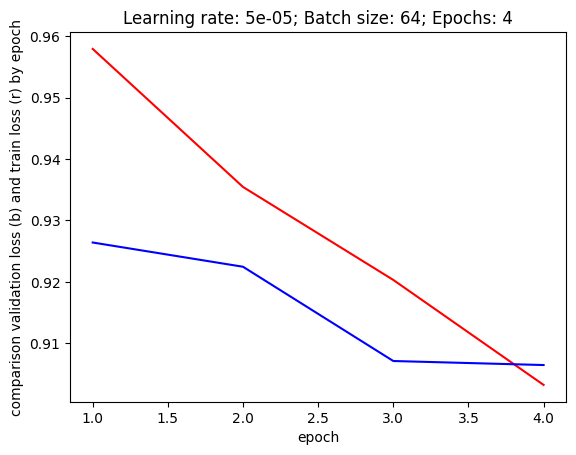

In [26]:
plt.plot(list(range(1, EPOCHS+1)), train_loss_epoch, 'r')
plt.plot(list(range(1, EPOCHS+1)), valid_loss_epoch, 'b')
plt.ylabel('comparison validation loss (b) and train loss (r) by epoch')
plt.xlabel('epoch')
plt.title('Learning rate: ' + str(LEARNING_RATE) + '; Batch size: ' + str(TRAIN_BATCH_SIZE) + '; Epochs: ' + str(EPOCHS))
plt.show()

# Read the model

In [27]:
pred_model = BERTClass()
pred_model.to(device)
model = load_checkpoint(BEST_MODEL_PATH, pred_model, optimizer)

Loaded model with the weighted F1-Score of: 0.49811407923698425 and epoch: 4


In [28]:
pred_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")

# Test data

In [29]:
test_output = torch.Tensor().to(device)
test_target = torch.Tensor().to(device)

for index, row in test_data.iterrows():
    input_ids, attention_mask, token_type_ids = get_encodings(row["c_text"], row["reaction1"], row["reaction2"])
    pred_model.eval()
    with torch.no_grad():
        input_ids = input_ids.to(device, dtype=torch.long)
        attention_mask = attention_mask.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        
        targets = torch.Tensor([[row["Generalisation0"], row["Generalisation1"], row["Generalisation2"], row["Generalisation3"], row["Ambiguous"], row["Objective"], row["Subjective"], row["Disputed"]]])
        targets = targets.to(device, dtype=torch.float)
        
        outputs = pred_model(input_ids, attention_mask, token_type_ids)
        outputs = torch.Tensor(outputs)
        outputs = outputs.to(device, dtype=torch.float)
        
        test_output = torch.cat((test_output, outputs), dim=0)
        test_target = torch.cat((test_target, targets), dim=0)

test_metrics = metrics_function(test_output, test_target)
test_accuracy = accuracy_function(test_output, test_target)
test_f1_score, valid_f1_score_weight = f1_score_function(test_output, test_target)

print(f'\tTest: \n\t\t{test_metrics} \n\t\t{test_accuracy} \n\t\t{test_f1_score}')
del test_metrics, test_accuracy, test_f1_score
torch.cuda.empty_cache()

	Test: 
		Metrics [TP, FP, TN, FN, SUP]: 	None: tensor([[ 73,  13,  64,  92, 165],
        [ 17,  42, 154,  29,  46],
        [  7,  30, 188,  17,  24],
        [  1,  36, 200,   5,   6],
        [  9,  26, 170,  37,  46],
        [ 27,  44, 150,  21,  48],
        [ 98,   2,  30, 112, 210],
        [ 45,  70, 115,  12,  57]], device='cuda:0') 	Micro: tensor([ 277,  263, 1071,  325,  602], device='cuda:0') 	Macro: tensor([ 34.6250,  32.8750, 133.8750,  40.6250,  75.2500], device='cuda:0') 	Weighted: tensor([ 62.8837,  21.1478,  85.1013,  72.8671, 135.7508], device='cuda:0') 
		Accuracy: 	None: tensor([0.5661, 0.7066, 0.8058, 0.8306, 0.7397, 0.7314, 0.5289, 0.6612],
       device='cuda:0') 	Micro: 0.6962810158729553 	Macro: 0.6962809562683105 	Weighted: 0.6115084886550903 
		F1 Score: 	None: tensor([0.5817, 0.3238, 0.2295, 0.0465, 0.2222, 0.4538, 0.6323, 0.5233],
       device='cuda:0') 	Micro: 0.48511382937431335 	Macro: 0.3766275644302368 	Weighted: 0.5170466899871826


# Get Predictions

In [30]:
def get_prediction(row): 
    input_ids, attention_mask, token_type_ids = get_encodings(row["c_text"], row["reaction1"], row["reaction2"])
    
    pred_model.eval()
    with torch.no_grad():
        input_ids = input_ids.to(device, dtype=torch.long)
        attention_mask = attention_mask.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        
        outputs = pred_model(input_ids, attention_mask, token_type_ids)
        
        generalisation_pred_value = 0
        generalisation_pred_prop = 0
        if outputs[0][0].item() > generalisation_pred_prop:
            generalisation_pred_value = 0
            generalisation_pred_prop = outputs[0][0].item()
        
        if outputs[0][1].item() > generalisation_pred_prop:
            generalisation_pred_value = 1
            generalisation_pred_prop = outputs[0][1].item()
            
        if outputs[0][2].item() > generalisation_pred_prop:
            generalisation_pred_value = 2
            generalisation_pred_prop = outputs[0][2].item()
        
        if outputs[0][3].item() > generalisation_pred_prop:
            generalisation_pred_value = 3
        
        row['Generalisation_Pred'] = generalisation_pred_value
        row['Ambiguous_Pred'] = 1 if outputs[0][4].item() > 0.5 else 0
        row['Objective_Pred'] = 1 if outputs[0][5].item() > 0.5 else 0
        row['Subjective_Pred'] = 1 if outputs[0][6].item() > 0.5 else 0
        row['Disputed_Pred'] = 1 if outputs[0][7].item() > 0.5 else 0
        
        return row

In [31]:
data_pred = []
for index, row in sample_data.iterrows():
    data_pred.append(get_prediction(row))
    
data_pred = pd.DataFrame(data_pred)
data_pred.head()

,c_id,c_text,date,conv_id,reaction1,reaction2,Ambiguous,Objective,Subjective,Disputed,Generalisation0,Generalisation1,Generalisation2,Generalisation3,Generalisation_Pred,Ambiguous_Pred,Objective_Pred,Subjective_Pred,Disputed_Pred
1485,1405047474310553601,"Nein, nicht in einen Tiopf. Die Mitesser-NGO G...",16.06.2021 06:19,1.404880e+18,Ich werte das als impulsgetiebene Antwort. Bit...,Jeder Mensch mit klarem Verstand erkennt bei d...,1.0,0.0,1.0,1.0,1,0,0,0,1,0,1,1,1
1487,1393517517927223301,"Ääähm... da müsste man halt jetzt wissen, dass...",15.05.2021 10:44,1.393101e+18,100%. Ich hoffe er schreibt es sich hinter sei...,Es ist immer wieder schön zu sehen und zu höre...,0.0,1.0,1.0,0.0,0,1,0,0,1,0,1,1,1
1492,1388783647403220994,"Wer liest das? Mal ehrlich jetzt, wenn dieses ...",02.05.2021 09:13,1.388210e+18,"Sie fragen, weshalb er ein Faschist sei. Ich b...",Dann sagen Sie es mir?,1.0,0.0,1.0,1.0,0,1,0,0,0,0,0,0,1
1493,1387373196916281344,"Im Gegensatz etwa zum ""Flügel"" der AfD damals....",28.04.2021 11:48,1.387325e+18,Jetzt wird's aber sehr beliebig. Sind denn der...,Das negieren des staatlichen Gewaltmonopols is...,0.0,1.0,1.0,1.0,1,0,0,0,1,0,1,1,1
1505,1404378018928267264,"Biergarten ist gesellschaftlich notwendiger, g...",14.06.2021 09:59,1.403864e+18,Du scheinst dich sehr auf Herrn Reitschuster e...,Dafür hattet ihr ne Ausgangssperre 😉,0.0,1.0,1.0,1.0,0,0,1,0,1,0,1,1,1


In [32]:
data_pred.to_csv('dataset/05_predictions-for-test-comments.csv', sep=';', index=False, header=True, encoding='utf-8-sig') 